In [1]:
%pylab inline
from crossSection import CrossSection
from ShapeGen import genCirc
from numpy.random import rand,seed

Populating the interactive namespace from numpy and matplotlib


In [16]:
Q = 0.15
nx = 6
xs =linspace(0,500,nx)
zs = linspace(0,1,nx)
seed(5)
rs = 0.1 + rand(nx-1)#*ones(nx-1)
slopes = (zs[1:] - zs[:-1])/(xs[1:] - xs[:-1])
Ls = xs[1:]- xs[:-1]
f=0.1
#Generate cross-sections
xcs = []
maxdepths = []
for r in rs:
    x, y = genCirc(r)
    xc = CrossSection(x,y)
    xcs.append(xc)
    maxdepths.append(xc.ymax-xc.ymin)
    
#Calculate flow depths
h = zeros(nx)
for i, xc in enumerate(xcs):
    #Try calculating flow depth
    fd = xc.calcNormalFlowDepth(Q,slopes[i],f=f)
    print('h-z=',h[i]-zs[i+1], '  maxdepth=',maxdepths[i])
    if fd ==-1 or (h[i]-zs[i+1])>maxdepths[i]:
        print('Pipe ',i,' is full')
        if i==0:
            h[0]=maxdepths[0]
        #We have a full pipe, calculate head gradient instead
        delh = xc.calcPipeFullHeadGrad(Q,slopes[i],f=f)
        print(delh*(xs[i+1] - xs[i]))
        h[i+1] = h[i] + delh * (xs[i+1] - xs[i])
    elif fd < h[i] - zs[i+1]:#upstream node is flooded above normal depth
        print('Pipe ',i,' is backflooded')
        y_out = h[i] - zs[i]
        y_in = xc.calcBackfloodDepth(Q,slopes[i],y_out,Ls[i],f=f)
        h[i+1] = zs[i+1] + y_in
    else:
        print('Pipe ',i,' is normal')
        if i==0:
            h[0] = fd
        #dz = slopes[i]*(x[i+1] - x[i])
        h[i+1] = zs[i+1] + fd


h-z= -0.2   maxdepth= 0.643985547690147
Pipe  0  is normal
h-z= 0.432948789728938   maxdepth= 1.9414622171596658
Pipe  1  is backflooded
h-z= 0.23838319399481467   maxdepth= 0.6134375538767878
Pipe  2  is full
0.2142397643356329
h-z= 0.25262295833044757   maxdepth= 2.0372193025445915
Pipe  3  is backflooded
h-z= 0.05967300427649036   maxdepth= 1.1768209257377116
Pipe  4  is normal


In [17]:
maxdepths

[0.643985547690147,
 1.9414622171596658,
 0.6134375538767878,
 2.0372193025445915,
 1.1768209257377116]

In [18]:
(xs[1]-xs[0])

100.0

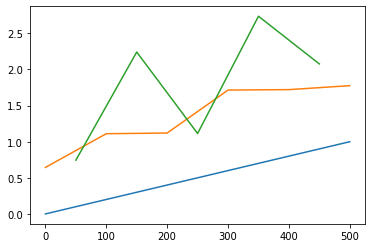

In [15]:
plot(xs,zs,xs,h)
xmid = (xs[1:] + xs[:-1])/2.
plot(xmid,maxdepths+(zs[1:] + zs[:-1])/2.)

In [11]:
ds = linspace(1e-6,xcs[0].ymax-xcs[0].ymin,100)
Q = zeros(100)
for i,y in enumerate(ds):
    Q[i] = xcs[0].calcNormalFlow(y,0.002)

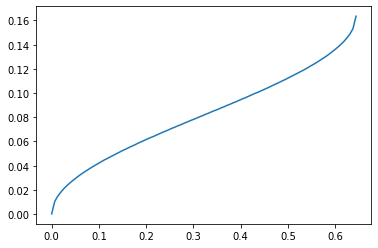

In [12]:
plot(ds,Q)

In [13]:
xcs[0].ymax-xcs[0].ymin

0.643985547690147